# ***XG-Boost Balanced***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import os
import random
import time
import joblib
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
from sklearn.neighbors import NearestNeighbors

import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_sample_weight
import lime.lime_tabular
import time

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])
from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
#optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_xgb_model_balanced.pkl"
study_filename = "../Study/optuna_study_XGB_nested_balanced.pkl"
metrics_filename = "../Models/best_xgb_metrics_balanced.pkl"
fold_metrics_filename = "./Metrics/xgb_folds_summary_balanced.csv"

In [4]:
class XGBWrapper:
    def __init__(self, params, numeric_features, categorical_features, use_adasyn=False):
        self.params = params.copy()
        self.num_boost_round = self.params.pop("num_boost_round")
        self.early_stopping_rounds = self.params.pop("early_stopping_rounds", None)
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.use_adasyn = use_adasyn
        self.preprocessor = self._build_preprocessor()
        self.model = None
        self.evals_result = None
        self.best_iteration = None
        self.best_score = None

    def _build_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='median'), self.numeric_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), self.categorical_features)
            ],
            remainder='drop',
            verbose_feature_names_out=False
        )

    def fit(self, X, y, eval_set=None):
        # fit and transform training data
        self.preprocessor = self.preprocessor.fit(X)
        X_proc = self.preprocessor.transform(X)

        if self.use_adasyn:
            nn = NearestNeighbors(n_neighbors=5, metric='manhattan')
            # ADASYN using Mahalanobis nearest neighbors
            ada = ADASYN(n_neighbors=nn, random_state=SEED)
            X_resampled, y_resampled = ada.fit_resample(X_proc, y)
            dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
        else:
            dtrain = xgb.DMatrix(X_proc, label=y)

        evals = [(dtrain, "train")]
        evals_result = {}

        if eval_set is not None:
            X_val, y_val = eval_set[0]
            X_val_proc = self.preprocessor.transform(X_val)
            dval = xgb.DMatrix(X_val_proc, label=y_val)
            evals.append((dval, "validation"))

        train_params = {
            'params': self.params,
            'dtrain': dtrain,
            'num_boost_round': self.num_boost_round,
            'evals': evals,
            'evals_result': evals_result,
            'verbose_eval': False
        }

        if self.early_stopping_rounds is not None and len(evals) > 1:
            train_params['early_stopping_rounds'] = self.early_stopping_rounds

        print("=== Training parameters ===")
        print(self.params)
        self.model = xgb.train(**train_params)
        self.evals_result = evals_result
        self.best_iteration = getattr(self.model, "best_iteration", None)
        self.best_score = getattr(self.model, "best_score", None)
        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        y_proba = self.model.predict(dmatrix)
        return np.argmax(y_proba, axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        return self.model.predict(dmatrix)

    def save(self, path):
        joblib.dump({
            "params": self.params,
            "num_boost_round": self.num_boost_round,
            "early_stopping_rounds": self.early_stopping_rounds,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
            "booster": self.model,
            "best_iteration": self.best_iteration,
            "best_score": self.best_score,
            "use_adasyn": self.use_adasyn
        }, path)

    @classmethod
    def load(cls, path):
        data = joblib.load(path)
        params = {**data["params"], "num_boost_round": data["num_boost_round"]}
        if "early_stopping_rounds" in data:
            params["early_stopping_rounds"] = data["early_stopping_rounds"]

        wrapper = cls(
            params,
            data["numeric_features"],
            data["categorical_features"],
            use_adasyn=data.get("use_adasyn", False)
        )
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = data["booster"]
        wrapper.best_iteration = data.get("best_iteration")
        wrapper.best_score = data.get("best_score")
        return wrapper

In [5]:
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "verbosity": 0,
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_inner)),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
            "max_depth": trial.suggest_int("max_depth", 4, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "tree_method": "hist",
            "device": "cuda",
            "seed": SEED,
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 300),
            "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 5, 30),
        }

        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_float("rate_drop", 0.1, 0.5)
            params["skip_drop"] = trial.suggest_float("skip_drop", 0.0, 0.5)

        model = XGBWrapper(params, numeric_features, categorical_features, use_adasyn=True)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []

        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]

            eval_set = [(X_v, y_v)]
            model.fit(X_t, y_t, eval_set=eval_set)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))

        return np.mean(scores)

    pruner = optuna.pruners.MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=10)
    return study.best_params, study

In [6]:
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores,
                                     mode='lines+markers', name='F1-score'))
            fig.update_layout(
                title='F1-Score Evolution During Optuna Optimization',
                xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark'
            )
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time
        optuna_studies.append(study)

        best_params["objective"] = "multi:softprob"
        best_params["num_class"] = 3       
        best_params["tree_method"] = "hist"
        best_params["device"] = "cuda"
        best_params["verbosity"] = 3
        best_params["seed"] = SEED

        model = XGBWrapper(best_params, numeric_features, categorical_features, use_adasyn=True)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = \
            me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = \
            me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = \
            me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores,
                             mode='lines+markers', name='F1-score'))
    fig.update_layout(
        title='F1-Score Evolution During Optuna Optimization',
        xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark'
    )
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [7]:
# Run pipeline
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3426
           1       0.80      0.75      0.77      1034
           2       0.81      0.74      0.77       625

    accuracy                           0.89      5085
   macro avg       0.84      0.81      0.83      5085
weighted avg       0.89      0.89      0.89      5085



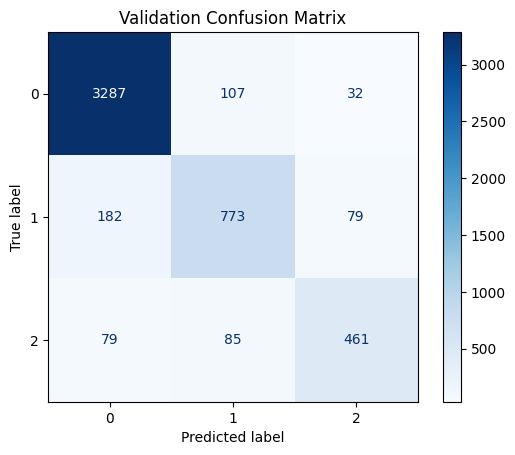

In [9]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [10]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4282
           1       0.81      0.74      0.77      1292
           2       0.82      0.71      0.76       781

    accuracy                           0.89      6355
   macro avg       0.85      0.81      0.83      6355
weighted avg       0.89      0.89      0.89      6355



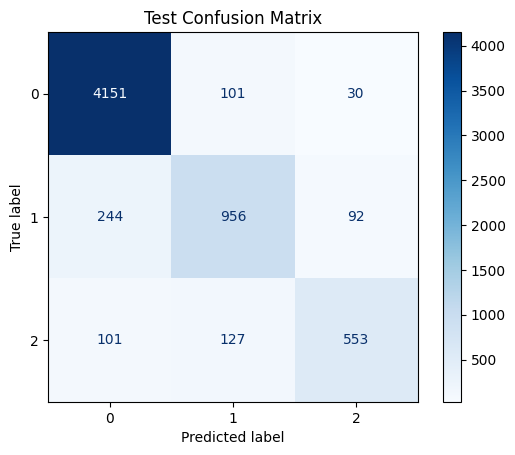

In [11]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

In [12]:
def plot_loss_curves(model):
    """
    Plots train and validation log loss over boosting rounds.
    Adds a vertical line at the best_iteration if available.
    """
    if not hasattr(model, "evals_result"):
        raise ValueError("The model has no evaluation history.")

    results = model.evals_result
    for dataset in results:
        if "mlogloss" in results[dataset]:
            plt.plot(results[dataset]["mlogloss"], label=f"{dataset} logloss")

    plt.xlabel("Boosting round")
    plt.ylabel("Log loss")
    plt.title("Log loss - train vs validation")
    plt.legend()
    plt.grid(True)

    if hasattr(model, "best_iteration") and model.best_iteration is not None:
        plt.axvline(x=model.best_iteration, color="red", linestyle="--", label="Best iteration")
        plt.legend()

    plt.show()


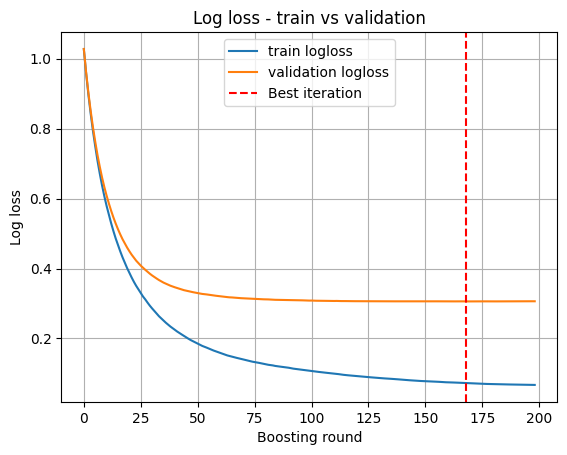

In [13]:
plot_loss_curves(model)

--- Explanation for class 0 ---


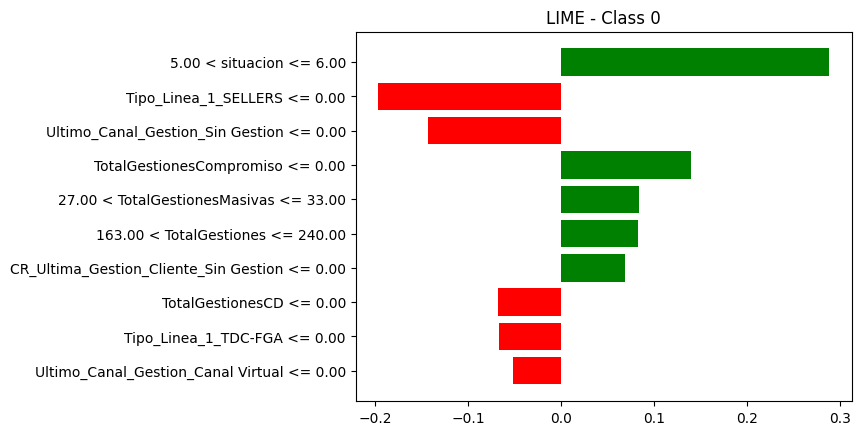

--- Explanation for class 1 ---


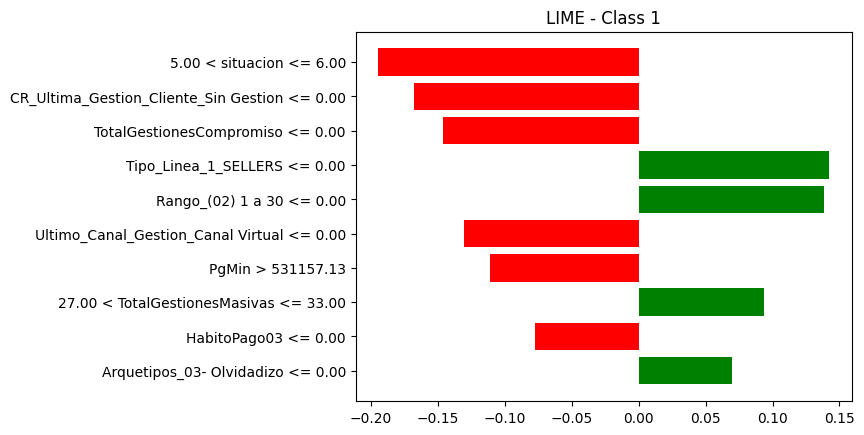

--- Explanation for class 2 ---


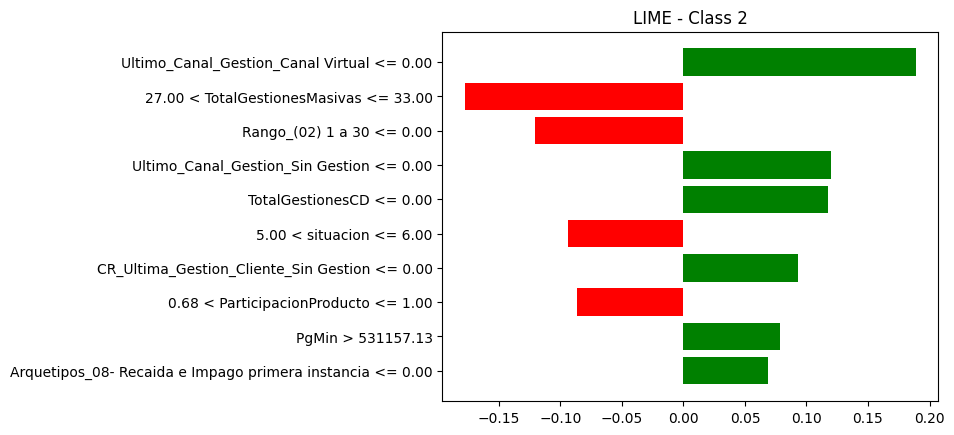

In [14]:
X_transformed = model.preprocessor.transform(metrics['X_train_fold'])

def predict_fn(x):
    dmatrix = xgb.DMatrix(x)
    return model.model.predict(dmatrix)

feature_names = model.preprocessor.get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance = X_transformed[10]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [15]:
visualizations['optimization_history']

In [16]:
visualizations['parallel_coordinate']

In [17]:
visualizations['f1_score_evolution']

In [18]:
visualizations['param_importances']

In [19]:
raw_importances = model.model.get_score(importance_type='gain')

feature_names = model.preprocessor.get_feature_names_out()

mapped_importances = []
for i, fname in enumerate(feature_names):
    score = raw_importances.get(f"f{i}", 0)
    mapped_importances.append((fname, score))

importance_df = pd.DataFrame(mapped_importances, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)

fig = px.bar(
    importance_df,
    x='Feature',
    y='Importance',
    title='Top 20 Feature Importance - XGBoost',
    labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
    color='Importance',
    color_continuous_scale='Viridis',
    text='Importance'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [20]:
reporte.save(metrics, model_name="XGBOOST_Balanced")


Report for model 'XGBOOST_Balanced' saved:
   → CSV: ./Metrics/Metrics_XGBOOST_Balanced.csv
   → JSON: ./Metrics/Metrics_XGBOOST_Balanced.json


In [21]:
df = reporte.load()


Loaded 9 report(s)


In [22]:
df.query("Model == 'XGBOOST_Balanced' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
150,XGBOOST_Balanced,val,0,0.926,0.959,0.943
151,XGBOOST_Balanced,val,1,0.801,0.748,0.773
152,XGBOOST_Balanced,val,2,0.806,0.738,0.77
153,XGBOOST_Balanced,val,macro avg,0.844,0.815,0.829
154,XGBOOST_Balanced,val,weighted avg,0.886,0.889,0.887


In [23]:
df.query("Model == 'XGBOOST_Balanced' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
156,XGBOOST_Balanced,test,0,0.923,0.969,0.946
157,XGBOOST_Balanced,test,1,0.807,0.74,0.772
158,XGBOOST_Balanced,test,2,0.819,0.708,0.76
159,XGBOOST_Balanced,test,macro avg,0.85,0.806,0.826
160,XGBOOST_Balanced,test,weighted avg,0.887,0.891,0.888


In [ ]:
df.query("Model == 'XGBOOST_Balanced' and auc != '-' and Type != 'train'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
149,XGBOOST_Balanced,train,0.985,0.085,0.999
155,XGBOOST_Balanced,val,0.889,0.306,0.963
161,XGBOOST_Balanced,test,0.891,0.305,0.966


In [25]:
df.query("Model == 'XGBOOST_Balanced' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
155,XGBOOST_Balanced,val,0.889,0.306,0.963


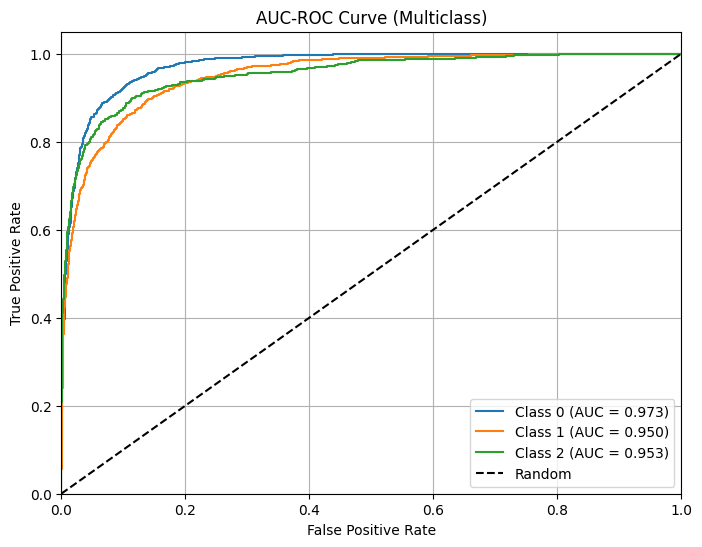

In [26]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [27]:
model.params  

{'booster': 'gbtree',
 'lambda': 0.004510853162496441,
 'alpha': 0.3637540167048938,
 'subsample': 0.701357851033058,
 'colsample_bytree': 0.9393733763046879,
 'colsample_bylevel': 0.8355255116512859,
 'max_depth': 9,
 'min_child_weight': 2,
 'gamma': 0.6662363940765178,
 'learning_rate': 0.07578743412311638,
 'objective': 'multi:softprob',
 'num_class': 3,
 'tree_method': 'hist',
 'device': 'cuda',
 'verbosity': 3,
 'seed': 42}